# Example 5.1: Narrowbanded processes



## Ideal narrow banded process 

### Auto spectral density


Narrowbanded processes are stochastic processes whose spectral energy is concentrated in a narrow range of frequencies. We now consider an idealized narrowbanded process, with a rectangular spectrum in a small interval between $\omega_1$ and $\omega_2$:

$$
S(\omega) 
= \left\{ \begin{array}  a  \sigma_x^2 / (\omega_2-\omega_1) & \quad 
\omega_1 \leq  \omega  \leq \omega_2
\\ 0 & \quad \text{elsewhere} \end{array} \right.
$$

$\omega_1$ and $\omega_2$ are the lower and upper cut-off frequencies. The $\Delta \omega = \omega_2- \omega_1$ is called the bandwidth.


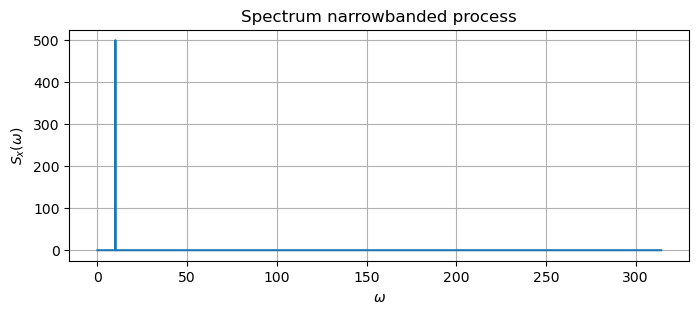

In [56]:
# Import necessary packages and modules
import numpy as np
from scipy import linalg as spla
import sys
sys.path.append('./../modules')
from time_integration import * # Import all functions in the module time_integration
from matplotlib import pyplot as plt 

T=500
dt=0.02

N=int(T/dt)

t=np.arange(0,N,1)*dt # Time axis

domega=2*np.pi/T # Frequency spacing
omega_axis = np.arange(0,N,1)*domega # Frequency axis

# Load spectrum

omega1 = 9.9 # Low cut-off frequency
omega2 = 10 # Upper cut-off frequency
sigma_x= 10.0 # Standard deviation of the process

Sx=np.zeros_like(omega_axis)
Sx[(np.abs(omega_axis) < omega2) & (np.abs(omega_axis) > omega1)] = 0.5*sigma_x**2/(omega2-omega1)

plt.figure(figsize=(8,3))
plt.plot(omega_axis,Sx)
plt.title('Spectrum narrowbanded process')
plt.ylabel(r'$S_x(\omega)$')
plt.xlabel(r'$\omega$')
plt.grid()

### Time series simulation


Text(0.5, 1.0, 'Narrowbanded process')

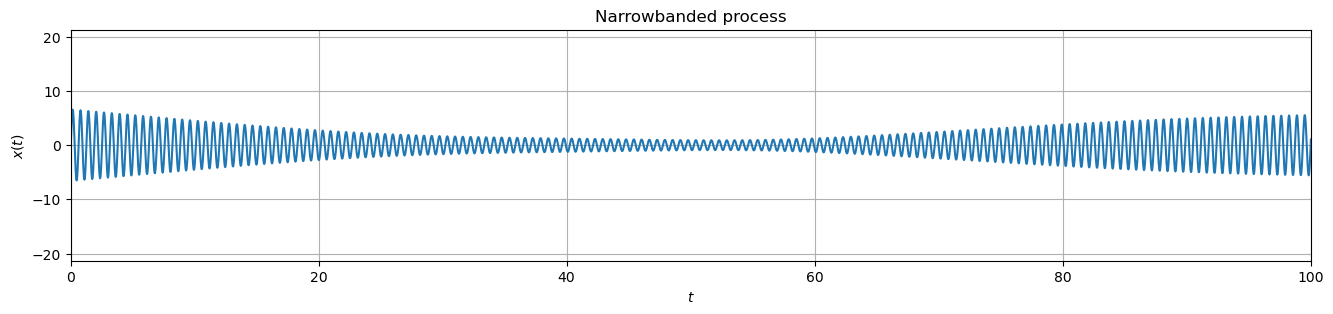

In [57]:

phi = np.random.rand(N)*2*np.pi # Random phase angles 
c_amp = (2*Sx*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x = np.real(np.fft.ifft(c_amp)*N) # The IFFT
omega_axis = np.arange(0,N,1)*domega # Frequency axis

plt.figure(figsize=(16,3))
plt.plot(t,x)
plt.grid()
plt.ylabel('$x(t)$')
plt.xlabel('$t$')
plt.xlim(0,T)
plt.xlim(0,100)
plt.title('Narrowbanded process')

## Dynamic response: narrowbanded approximation

The idealized narrowbanded spectrum as a rectangular peak is not very realistic for real-life stochastic processes. We can simulate response data for a 2-DOF dynamic system, and evalulate the validity of the narrowbanded approximation.

We will try two different load cases:

*i)* White noise (rectangular spectrum), which will excite both natural frequencies

*ii)* Wave-like spectrum, which will excite mainly the first natural frequency

### Shear frame

The shear frame has a mass $m=1$ kg and stiffness $N=100$ N/m. We will assign a Rayleigh damping.

The structure is only loaded in the top floor.

<center>
<img src="figures\shearframe.svg">
</center>


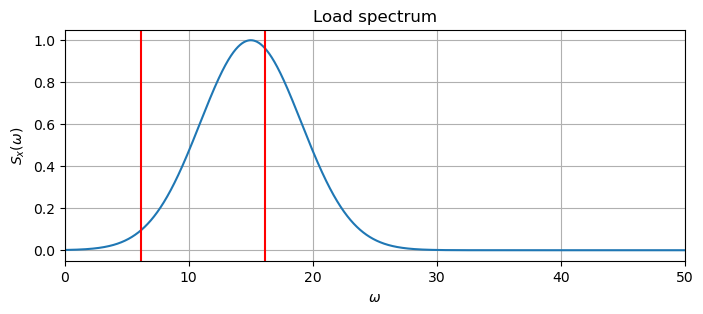

In [58]:
# Define structural properties
m = 1.0 # Mass of each story
k = 100.0 # Stiffness
M = np.eye(2)*m # Mass matrix
K = np.array(([[2, -1], [-1, 1]]))*k # Stiffness matrix

C = 0.4*M + 0.004*K # Rayleigh damping

lam,v = spla.eig(K,M) #Solve eigenvalue problem using scipy 
omega_n = np.real(lam)**0.5 # Natural frequencies in rad/s

T=1000
dt=0.01

N=int(T/dt)

t=np.arange(0,N,1)*dt # Time axis

domega=2*np.pi/T # Frequency spacing
omega_axis = np.arange(0,N,1)*domega # Frequency axis

# Load spectrum

# Rectangular spectrum
Sx=np.zeros_like(omega_axis)
Sx[(omega_axis>0) & (omega_axis<20)]=20

# Wave-like spectrum
Sx =np.exp(-0.1*(omega_axis-6)**2) # Excited modes 1 and 2
Sx =np.exp(-0.03*(omega_axis-15)**2) # Excited modes 1 and 2
Sx[0]=0

plt.figure(figsize=(8,3))
plt.plot(omega_axis,Sx)
plt.grid()
plt.ylabel('$S_x(\omega)$')
plt.xlabel('$\omega$')
plt.title('Load spectrum')
#plt.yscale('log')
plt.xlim(0,50)

plt.axvline(omega_n[0],color='r')
plt.axvline(omega_n[1],color='r')

### Response spectrum


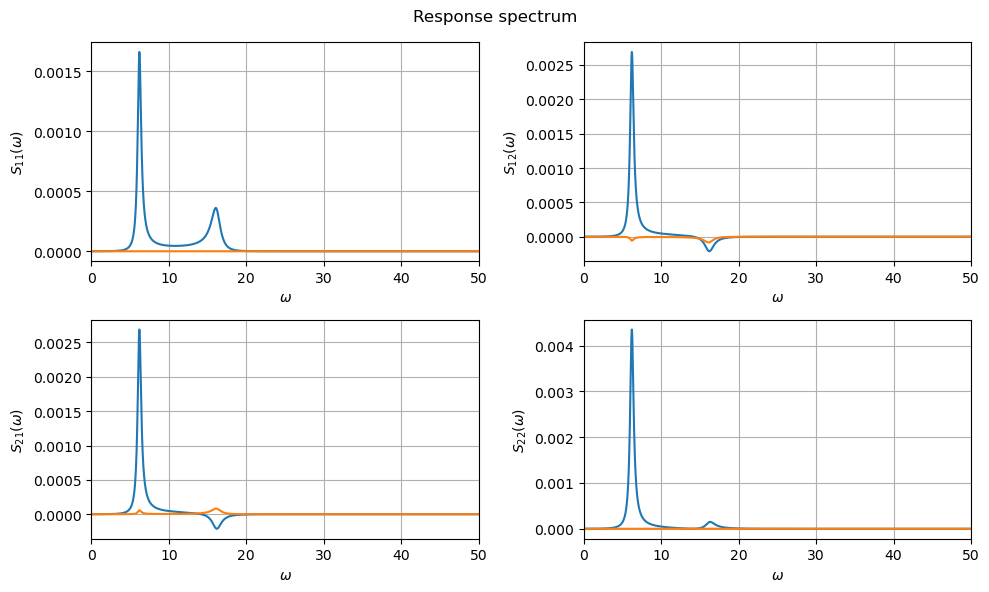

In [59]:
Sy=np.zeros((2,2,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):
    tmp=-omega_axis[k]**2*M+1j*omega_axis[k]*C+K
    H=np.linalg.inv(tmp)

    Sx_tmp=np.array([[0,0],[0,Sx[k]]])
    Sy[:,:,k]=H @ Sx_tmp @ np.conj(H).T

# Plot
fig, axs = plt.subplots(2, 2,figsize=(10, 6))

for i in np.arange(2):
    for j in np.arange(2):
        axs[i,j].plot(omega_axis,np.real(Sy[i,j,:]))
        axs[i,j].plot(omega_axis,np.imag(Sy[i,j,:]))
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,50)
        axs[i,j].grid(True)


fig.suptitle('Response spectrum')
plt.tight_layout()


### Displacement response simulation

We simulate the dynamic response directly from the calculated response spectrum.

Since we have only learned to simulate one-variable stochastic processes, we will look at $y_1$ only (element $[0,0]$ in $\mathbf{S}_\mathbf{y}(\omega)$).


(0.0, 100.0)

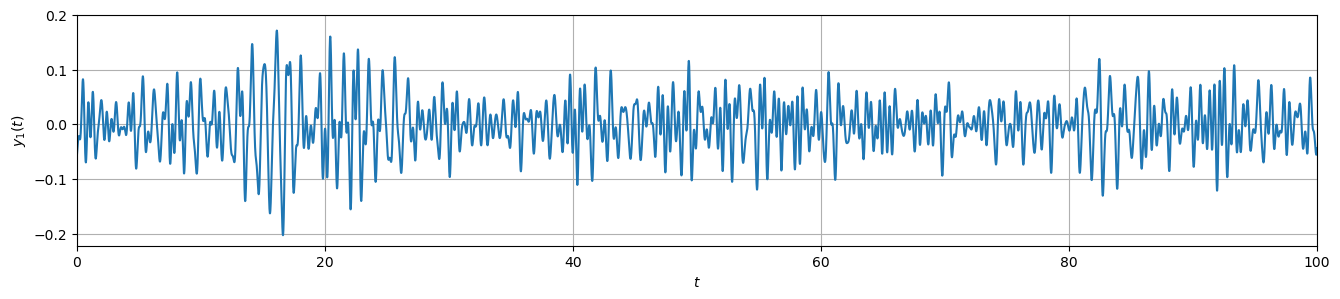

In [60]:
phi = np.random.rand(N)*2*np.pi # Random phase angles 
c_amp = (2*Sy[0,0,:]*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
y = np.real(np.fft.ifft(c_amp)*N) # The IFFT
omega_axis = np.arange(0,N,1)*domega # Frequency axis

plt.figure(figsize=(16,3))
plt.plot(t,y)
plt.grid()
plt.ylabel('$y_1(t)$')
plt.xlabel('$t$')
plt.xlim(0,T)
plt.xlim(0,100)


### Zero crossings and peaks

It is possible to find all peaks and zero crossings automatically.


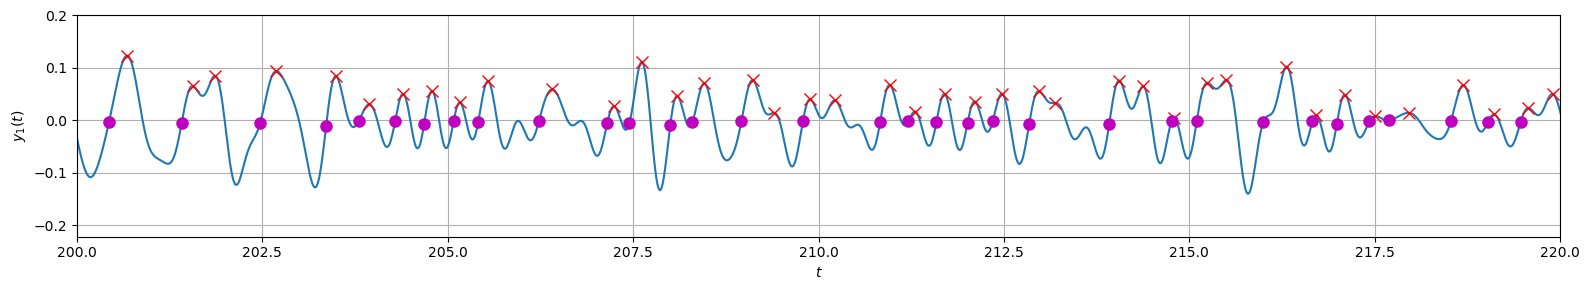

In [61]:
from scipy.signal import find_peaks

# Plot response
plt.figure(figsize=(16,3))
plt.plot(t,y)
plt.grid()
plt.ylabel('$y_1(t)$')
plt.xlabel('$t$')
plt.xlim(0,T)
plt.xlim(200,220)

plt.tight_layout()

# Find peaks
peaks=find_peaks(y, height=0)
idx_peak=peaks[0]

plt.plot(t[idx_peak], y[idx_peak],marker='x',color='r',linestyle='None',markersize=8)

# Find where the signal crosses from negative to positive (zero-crossing)
idx_zero_crossing = np.where((y[:-1] < 0) & (y[1:] > 0))[0]

# Plot zero crossing
plt.plot(t[idx_zero_crossing], y[idx_zero_crossing],marker='o',color='m',linestyle='None',markersize=8,label='Zero crossing')


For a narrowbanded process, the number of there should be (approximately) one peak per zero crossing.

In [62]:
print('Number of zero crossings = ' + str( len(idx_zero_crossing)))
print('Number of peaks = ' + str( len(idx_peak)))

Number of zero crossings = 1722
Number of peaks = 1987
